<a href="https://colab.research.google.com/github/annasajkh/StyleGAN3-CLIP-A-lot-of-Optimization/blob/main/StyleGAN3%2BCLIP%2BA_lot_of_Optimization_by_Annas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Optimizations is from https://arxiv.org/abs/2112.01573 i just modified it a bit
#Original method is from https://arxiv.org/abs/2103.17249
#Uses StyleGAN2, StyleGAN3, Distil StyleGAN2, Projected GAN, and CLIP you can actually change the generator to any GAN if you want
#Created by Annas
#twitter @AnnasVirtual

In [ ]:
#<--- just run that don't worry about the code

!pip install git+https://github.com/openai/CLIP.git
!pip install ninja
!pip install timm
!pip install gdown --upgrade
!git clone https://github.com/NVlabs/stylegan3.git
!git clone https://github.com/autonomousvision/projected_gan
!git clone https://github.com/autonomousvision/stylegan_xl

import torch
import clip
from torch.optim import AdamW
import torchvision.transforms as transforms
import math
from PIL import Image
from tqdm import tqdm
from math import sqrt, log
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from tqdm import tqdm
import numpy as np
from typing import Tuple
import os

normalize_clip = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

augmentation = nn.Sequential(
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomAffine(degrees=30, translate=(0.0, 0.3)),
    transforms.RandomCrop(size=(224, 224))
)

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, _ = clip.load("ViT-B/32", device=device)

def make_transform(translate: Tuple[float,float], angle: float):
    m = np.eye(3)
    s = np.sin(angle/360.0*np.pi*2)
    c = np.cos(angle/360.0*np.pi*2)
    m[0][0] = c
    m[0][1] = s
    m[0][2] = translate[0]
    m[1][0] = -s
    m[1][1] = c
    m[1][2] = translate[1]
    return m

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bu4mpban
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-bu4mpban
     |████████████████████████████████| 53 kB 1.7 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369221 sha256=a78753bd0816d35f38f6f787f527c1313499d2d5e8b8f0ca62acace7a7436161
  Stored in directory: /tmp/pip-ephem-wheel-cache-s97f8xuu/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip
     |████████████████████████████████| 108 kB 11.6 MB/s 
     |████████████████████████████████| 431 kB 11.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=5dd3aff7011dc0ba8d5bc605ebfee2d5d3943013119207f8be21d449f966318c
  Stored in directory: /root/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 100MiB/s]


In [ ]:
#if you want to change the model just change it here and run the cell

#ffhq = generate human faces
#afhqv2 = generate animals
#afhqcat = generate cats
#afhqdog = generate dogs
#cifar10 = generate objects
#horses  = generate horse
#bicycles = generate bicycle
#painting = generate painting
#landscape = generate landscape
#cityscape = generate cityscape
#human = generate full human body
#imagenet = generate image from imagenet

#change it here lmao
model_name = "ffhq"

if "stylegan3" not in os.listdir() and "projected_gan" not in os.listdir():
  %cd ../
  print("jump")

if model_name != "imagenet" model_name not in ["painting", "landscape", "cityscape"]:
  %cd stylegan3
  print("stylegan3")
elif model_name == "imagenet":
  %cd stylegan_xl
  print("stylegan_xl")
else:
  %cd projected_gan
  print("projected_gan")


import legacy

if model_name == "ffhq":
  !wget "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-256x256.pkl" -O "model.pkl" #i changed the model to 256x256 cuz it was really slow lol
  #you can change it back to stylegan2-ffhq-512x512.pkl if you want 
elif model_name == "afhqv2":
  !wget "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-afhqv2-512x512.pkl" -O "model.pkl" #512x512 model is so slow so be aware
elif model_name == "afhqcat":
  !wget "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-afhqcat-512x512.pkl" -O "model.pkl" #512x512 model is so slow so be aware
elif model_name == "afhqdog":
  !wget "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-afhqdog-512x512.pkl" -O "model.pkl" #512x512 model is so slow so be aware
elif model_name == "cifar10":
  !wget "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-cifar10-32x32.pkl" -O "model.pkl" #this one generate really low image quality
elif model_name == "horses":
  !wget "https://storage.googleapis.com/self-distilled-stylegan/horses_256_pytorch.pkl" -O "model.pkl" #distil stylegan2
elif model_name == "bicycles":
  !wget "https://storage.googleapis.com/self-distilled-stylegan/bicycles_256_pytorch.pkl" -O "model.pkl" #distil stylegan2
elif model_name == "painting":
  !wget "https://s3.eu-central-1.amazonaws.com/avg-projects/projected_gan/models/art_painting.pkl" -O "model.pkl" #projected gan
elif model_name == "landscape":
  !wget "https://s3.eu-central-1.amazonaws.com/avg-projects/projected_gan/models/art_painting.pkl" -O "model.pkl" #projected gan
elif model_name == "cityscape":
  !wget "https://s3.eu-central-1.amazonaws.com/avg-projects/projected_gan/models/cityscapes.pkl" -O "model.pkl" #projected gan
elif model_name == "human":
  !gdown --id 1dlFEHbu-WzQWJl7nBBZYcTyo000H9hVm #https://stylegan-human.github.io/
elif model_name == "imagenet":
  !wget "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet128.pkl" -O "model.pkl" #stylegan xl

if model_name != "human":
  with open("model.pkl", "rb")as file:
      G = legacy.load_network_pkl(file)["G_ema"].to(device)
else:
  with open("stylegan_human_v2_512.pkl", "rb")as file:
      G = legacy.load_network_pkl(file)["G_ema"].to(device)

# Construct an inverse rotation/translation matrix and pass to the generator.  The
# generator expects this matrix as an inverse to avoid potentially failing numerical
# operations in the network.
if hasattr(G.synthesis, "input"):
  m = make_transform((0, 0), 0)
  m = np.linalg.inv(m)
  G.synthesis.input.transform.copy_(torch.from_numpy(m))

/content/stylegan3
stylegan3
--2022-03-31 09:53:57--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-256x256.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 52.89.154.4, 44.238.198.213
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|52.89.154.4|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://prod-model-registry-ngc-bucket.s3.us-west-2.amazonaws.com/org/nvidia/team/research/models/stylegan2/versions/1/files/stylegan2-ffhq-256x256.pkl?response-content-disposition=attachment%3B%20filename%3D%22stylegan2-ffhq-256x256.pkl%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEHkaCXVzLXdlc3QtMiJHMEUCIQDEjn687%2FoucpoqJ2mOYYeNll9AdhziU25oC1ZlxywnWgIgLw83Xl85DffghsYT6oXqHC3hcr2i5Ozw9z3xztxPLXAq%2BgMIEhAEGgw3ODkzNjMxMzUwMjciDMrfb7Twz5QWL71uASrXA%2FJX8Q8taFn7GAZNUll%2Fp5qdurOmSbztxMQHwvNxj%2BYW48806sBhjyyHa9LNQOfdN5uek2krlCQ4az%2BIWyMV61tnvRqKfBEefiBulsU9Huo3BDx3eYf

In [ ]:
text = "obama smilling with glasses"

lr_init = 0.025

steps =  1000 
#increase the steps if you want better result

weight_decay = 0.01
 
image_augmentation_count = 4
 
init_image_augmentation_count = 4

init_vectors = 160 * 2
#increase the init vectors to get better results though it would be slow 

init_batch_size = 16
 
show_interval = 50

100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


min loss is 3.861328125


  0%|          | 0/1000 [00:00<?, ?it/s]


obama smilling with glasses
Loss: 3.916015625


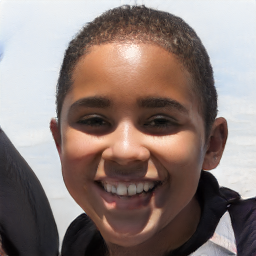

  5%|▌         | 50/1000 [00:26<08:21,  1.89it/s]


obama smilling with glasses
Loss: 2.841796875


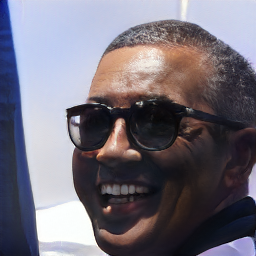

 10%|█         | 100/1000 [00:52<07:54,  1.90it/s]


obama smilling with glasses
Loss: 2.603515625


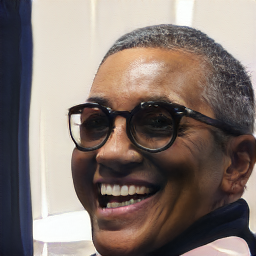

 15%|█▌        | 150/1000 [01:19<07:30,  1.89it/s]


obama smilling with glasses
Loss: 2.572265625


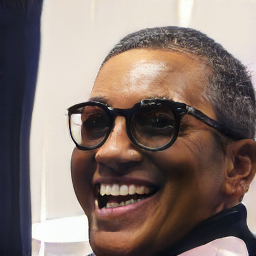

 20%|██        | 200/1000 [01:45<07:02,  1.90it/s]


obama smilling with glasses
Loss: 2.662109375


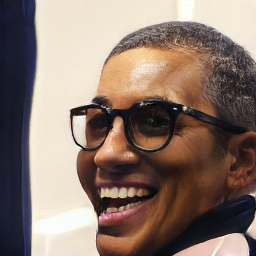

 25%|██▌       | 250/1000 [02:12<06:35,  1.90it/s]


obama smilling with glasses
Loss: 2.580078125


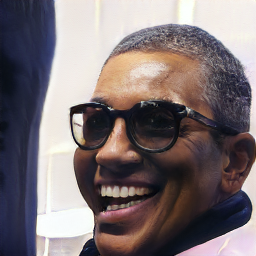

 30%|███       | 300/1000 [02:38<06:11,  1.89it/s]


obama smilling with glasses
Loss: 2.548828125


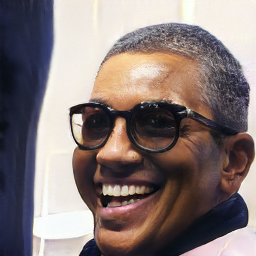

 35%|███▌      | 350/1000 [03:05<05:43,  1.89it/s]


obama smilling with glasses
Loss: 2.591796875


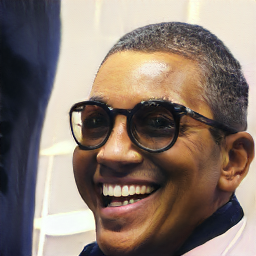

 38%|███▊      | 379/1000 [03:20<05:28,  1.89it/s]


KeyboardInterrupt: ignored

In [ ]:
text_tokenized = clip.tokenize([text]).to(device)
label = torch.zeros([init_batch_size, G.c_dim], device=device)
losses_latents = []

for i in tqdm(range(init_vectors // init_batch_size)):
    latents = torch.randn(init_batch_size, G.z_dim).to(device)
    
    with torch.no_grad():
        images = G(latents, label, truncation_psi=1, noise_mode="const")
        images = (images * 127.5 + 128).clamp(0, 255) / 255
        
        if images.shape[-1] != images.shape[-2]:
            images = F.pad(images, ((images.shape[-2] - images.shape[-1]) // 2, 
                                    (images.shape[-2] - images.shape[-1]) // 2), "constant", 0)
        
        images = normalize_clip(images)
        
        images = F.interpolate(images, (224, 224))
        
        count = 0

        for image in images:
            images_aug = torch.zeros(init_image_augmentation_count, 3, 224, 224).to(device)

            for j in range(init_image_augmentation_count - 1):
                images_aug[j] = augmentation(image)

            images_aug[-1] = image

            texts = torch.repeat_interleave(text_tokenized, init_image_augmentation_count, dim=0)
            
            losses_latents.append([1 / clip_model(images_aug, texts)[0].mean() * 100, latents[count].unsqueeze(0)])
            
            count += 1


min_loss = min([loss[0] for loss in losses_latents])

for loss_latent in losses_latents:
    if min_loss == loss_latent[0]:
        print(f"min loss is {loss_latent[0]}")
        latent = loss_latent[1]
        break
        
label = torch.zeros([1, G.c_dim], device=device)
latent = nn.Parameter(latent, requires_grad=True)

optimizer = AdamW([latent], lr=lr_init, weight_decay=weight_decay)

for i in tqdm(range(steps)):
    y = G(latent, label, truncation_psi=1, noise_mode="const")
    y_norm = (y * 127.5 + 128).clamp(0, 255) / 255
    
    if y_norm.shape[-1] != y_norm.shape[-2]:
        y_norm = F.pad(y_norm, ((y_norm.shape[-2] - y_norm.shape[-1]) // 2, 
                                (y_norm.shape[-2] - y_norm.shape[-1]) // 2), "constant", 0)
    
    img = normalize_clip(y_norm)
    
    image = F.interpolate(img, (224, 224))

    images = torch.zeros(image_augmentation_count, 3, 224, 224).to(device)
    
    for j in range(image_augmentation_count - 1):
        images[j] = augmentation(image)
    
    images[-1] = image
    
    texts = torch.repeat_interleave(text_tokenized, image_augmentation_count, dim=0)
    
    loss = 1 / clip_model(images, texts)[0].mean() * 100
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % show_interval == 0:
        print("\n" + text)
        print("Loss: " + str(loss.item()))
        
        with torch.no_grad():
            generated = (y.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
            display(Image.fromarray(generated[0].cpu().numpy(), "RGB"))
    
    

print(text)
print("Loss: " + str(loss.item()))

with torch.no_grad():
    generated = (y.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    display(Image.fromarray(generated[0].cpu().numpy(), "RGB"))